# Trip data duration regression

In [53]:
import pickle
import subprocess
from pathlib import Path

import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

PROJECT_DIR = Path().absolute().parent

## Download dataset

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page), but instead of "**Green** Taxi Trip Records", we'll use "**Yellow** Taxi Trip Records".

Download the data for January and February 2022.

In [54]:
DATA_DIR = PROJECT_DIR / "data"
S3_URL = "https://d37ci6vzurychx.cloudfront.net/trip-data/"
FILE_NAMES = ["yellow_tripdata_2022-01.parquet", "yellow_tripdata_2022-02.parquet"]


def download_data(file_name: str) -> None:
    file_path = DATA_DIR / file_name
    url = S3_URL + file_name

    if not file_path.is_file():
        print("File does not exist, downloading from S3 bucket.")
        if not file_path.parent.exists():
            file_path.parent.mkdir(parents=True)
        subprocess.run(["wget", "-O", file_path, url])
        print(f"File downloaded successfully and saved at {file_path}")
    else:
        print("File already exists.")


for file_name in FILE_NAMES:
    download_data(file_name)

File already exists.
File already exists.


Read the data for January. How many columns are there?

In [55]:
df = pd.read_parquet(DATA_DIR / FILE_NAMES[0])
print(
    f"There are currently {df.shape[0]} rows and {df.shape[1]} columns in the dataset."
)

There are currently 2463931 rows and 19 columns in the dataset.


## Set target

Our target column is `duration`. It should contain the duration of a ride in minutes. What's the standard deviation of the trips duration in January?


In [56]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [57]:
df["duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
df["duration"] = df["duration"].apply(lambda td: td.total_seconds() / 60)

duration_std = df["duration"].std()

print(f"The standard deviation of the trip duration is {duration_std:.2f} minutes.")

The standard deviation of the trip duration is 46.45 minutes.


## Cleaning

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [58]:
original_shape = df.shape
df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]
clean_rows_pct = df.shape[0] / original_shape[0] * 100

print(f"{clean_rows_pct=:.2f}%.")

clean_rows_pct=98.28%.


## Train linear regression

In [59]:
categorical_cols = ["PULocationID", "DOLocationID"]

pipeline = Pipeline(
    [
        (
            "encoder",
            ColumnTransformer(
                [
                    (
                        "one_hot_encoder",
                        OneHotEncoder(handle_unknown="ignore"),
                        categorical_cols,
                    )
                ],
                remainder="passthrough",
            ),
        )
    ]
)
X_train = pipeline.fit_transform(df[categorical_cols])

# Get the number of columns
dimensionality = X_train.shape[1]
print(f"{dimensionality=}")

dimensionality=515


In [60]:
target = "duration"
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

6.986190836160848

<Axes: ylabel='Count'>

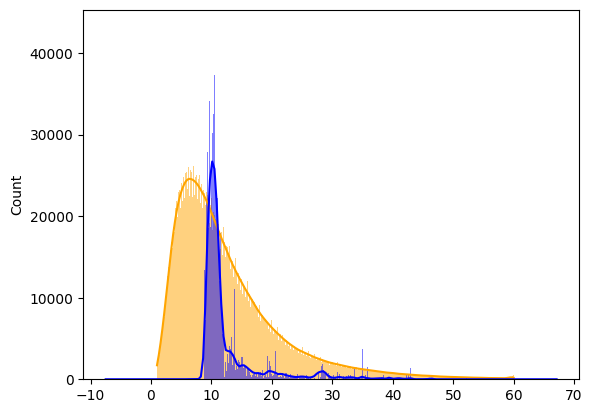

In [61]:
sns.histplot(y_train, color="orange", edgecolor=None, alpha=0.5, kde=True)
sns.histplot(y_pred, color="blue", edgecolor=None, alpha=0.5, kde=True)

In [62]:
def _read_csv_dataframe(filename: Path) -> pd.DataFrame:
    df = pd.read_csv(filename)
    for dt_col in ["lpep_dropoff_datetime", "lpep_pickup_datetime"]:
        df[dt_col] = pd.to_datetime(df[dt_col])
    return df


def _is_file_csv(filename: Path) -> bool:
    return filename.suffix == ".csv"


def _is_file_parquet(filename: Path) -> bool:
    return filename.suffix == ".parquet"


def load_clean_data(filename: Path) -> pd.DataFrame:
    if _is_file_csv(filename):
        df = _read_csv_dataframe(filename)
    elif _is_file_parquet(filename):
        df = pd.read_parquet(filename)

    df["duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    df["duration"] = df["duration"].apply(lambda td: td.total_seconds() / 60)

    df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]
    return df

In [63]:
df_val = load_clean_data(DATA_DIR / "yellow_tripdata_2022-02.parquet")
X_val = pipeline.transform(df_val[categorical_cols])
y_val = df_val[target].values
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

7.78640919129931